{'1000': 1, '1001': 12, '0000': 852, '0001': 135}


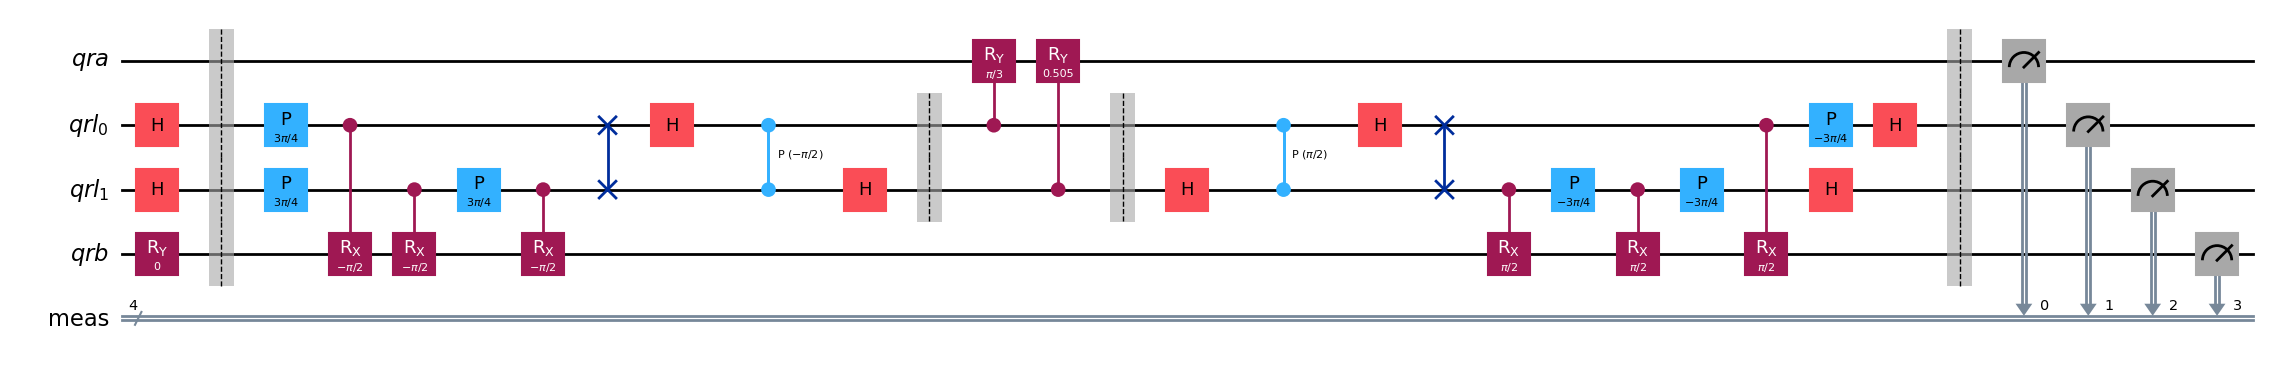

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np

################
## 前提：
## HHLアルゴリズムは、量子コンピュータを用いて 線形方程式 𝐴𝑥=𝑏のような線形方程式を解くことを目的とた 量子アルゴリズムです。
## 𝐴は 𝑁×𝑁 のエルミート行列（または適切に変換可能な行列）。
    # エルミート行列とはA=A†であること。A †は エルミート共役（共役転置） 。
    # エルミート行列の特徴
    # (1) 固有値はすべて実数
    # (2) 固有ベクトルは直交する
    # (3) ユニタリ変換で対角化できる
      # ユニタリ行列とは、行列 𝑈がそのエルミート共役（共役転置）と掛けたときに単位行列になる行列のことです。UU†=U†U=I
      # ユニタリ変換とは、あるベクトルや行列をユニタリ行列を使って変換する操作のことです。
      # これは、以下の形で表されます：
      # 𝑣′=𝑈𝑣
      # または、行列をユニタリ変換する場合：
      # 𝐴′=𝑈𝐴𝑈†
## 𝑏は 既知のベクトル𝑥 は 求める解ベクトル
## 
## このコードでは、以下の流れでHHLアルゴリズムを実装しています：
## ・𝐴と ∣𝑏⟩ の準備
## ・量子位相推定（QPE）
## ・固有値の逆数操作
## ・逆量子フーリエ変換（IQFT）
## ・測定による出力
################


# ビット数、tの値
nb, nl, theta = 1, 2, 0
t = 2 * np.pi * 3 / 8

## nb = 1 : 解ベクトル 𝑥を表す量子ビット数
## nl = 2 : 量子位相推定（QPE）用の補助量子ビット数
## theta = 0 : 入力状態の回転角
## t = 2π × 3/8 : 演算に必要なパラメータ


# 量子ビットの準備
qrb = QuantumRegister(nb, name='qrb')  # ベクトル b の量子ビット
qrl = QuantumRegister(nl, name='qrl')  # 量子位相推定用の補助量子ビット
qra = QuantumRegister(1, name='qra')   # 固有値逆数演算用の補助ビット

# 量子回路(QuantumCircuit) を作成
qc = QuantumCircuit(qra, qrl, qrb)

# 入力状態∣𝑏⟩を作成
qc.ry(2 * theta, qrb[0])

# 量子位相推定
for qu in qrl:
    # アダマール変換 を適用し、QPEの準備
    qc.h(qu)

qc.barrier()
  # 制御位相回転 𝑃(𝑡) と 制御 𝐶𝑅𝑋 ゲート を使って行列 𝐴の固有値情報を得る
qc.p(t, qrl[0])
qc.crx(-2 / 3 * t, qrl[0], qrb[0])
qc.p(t, qrl[1])
qc.crx(-2 / 3 * t, qrl[1], qrb[0])
qc.p(t, qrl[1])
qc.crx(-2 / 3 * t, qrl[1], qrb[0])

# 逆量子フーリエ変換
  # 量子フーリエ変換（QFT）を逆に適用
  # 𝐴の固有値の情報を回収
qc.swap(qrl[0], qrl[1])
qc.h(qrl[0])
qc.cp(-np.pi / 2, qrl[0], qrl[1])
qc.h(qrl[1])

# 固有値の逆数の回転
  # λ−1 の計算（固有値の逆数を取得） 
  # CRYゲート（制御回転） を適用し、逆数演算を反映
c = 1/3
t1 = 2 * np.arcsin(1 / 2)
t2 = 2 * np.arcsin(1 / 4)

qc.barrier(qrl)
qc.cry(t1, qrl[0], qra[0])
qc.cry(t2, qrl[1], qra[0])
qc.barrier(qrl)

# 量子フーリエ変換
  # 量子フーリエ変換（QFT）を適用し、元の基底に戻す
qc.h(qrl[1])
qc.cp(np.pi / 2, qrl[0], qrl[1])
qc.h(qrl[0])
qc.swap(qrl[0], qrl[1])

# 逆量子位相推定
  # QPEの逆操作 を実施し、解の量子状態を得る
qc.crx(2 / 3 * t, qrl[1], qrb[0])
qc.p(-t, qrl[1])
qc.crx(2 / 3 * t, qrl[1], qrb[0])
qc.p(-t, qrl[1])
qc.crx(2 / 3 * t, qrl[0], qrb[0])
qc.p(-t, qrl[0])

for qu in qrl:
    qc.h(qu)

# 測定
qc.measure_all()

# シミュレーションの設定
simulator = AerSimulator()

# トランスパイルと実行
  # トランスパイル（transpile） とは、量子回路を実際の量子コンピュータやシミュレーター上で実行できる形に変換する処理 
compiled_circuit = transpile(qc, simulator)
result = simulator.run(compiled_circuit, shots=1000).result()

# 結果の取得と表示
counts = result.get_counts()
print(counts)
# plot_histogram(counts)
qc.draw(output='mpl', fold=100)


# 修正点の説明
# executeの置き換え: AerSimulatorを使用して、シミュレーションの実行を行っています。
# トランスパイルの追加: 量子回路をバックエンドに最適化するために、トランスパイル処理を追加しました。
# plot_histogramの保持: 結果を視覚化するために、ヒストグラムを表示しています。


# HHLアルゴリズムが複雑なのは、以下の理由がある為
# 1.行列の固有値計算が必要
# 　・古典的な方法では 𝑂(𝑁3)かかるが、HHLは 𝑂(log𝑁)にできる（条件が良ければ）
# 　・ただし、量子位相推定（QPE）は量子ゲートを多く使うため、回路が大きくなる
# 2.逆数計算を量子状態で行う必要がある
# 　・1/𝜆_𝑖を直接計算するのではなく、量子ゲートを使って近似する
# 　・これが一番難しい部分
# 3.最終的な解は量子状態として得られる
# 　・∣𝑥⟩を測定するには、測定回数を増やして期待値を求める必要がある

# HHLは本当に役立つのか？
# ・理論的には、HHLは 指数的なスピードアップ を提供できる（𝑂(log𝑁) で解ける）
# ・実際には、量子コンピュータの誤差や条件数の問題で、まだ実用化は難しい
# ・しかし、量子機械学習（QML） など、将来的な応用が期待されている

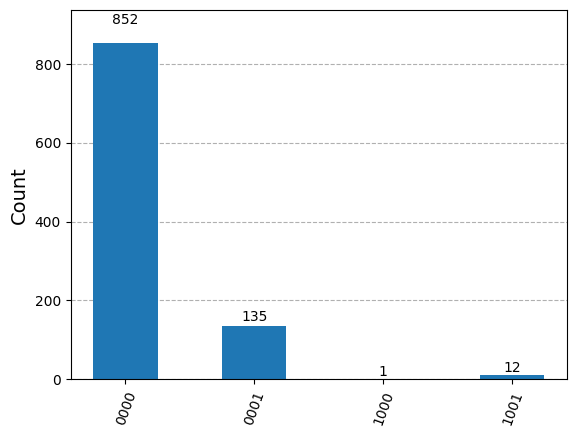

In [2]:
plot_histogram(counts)